```@meta
CurrentModule = LaplaceRedux
```

## Multi-class problem

NOTE: This notebook was converted from `multi.qmd`.

Overview of the testing process is as follows:
1. `(jl)` ~~Generate the data in Julia, export as CSV to be used in Python.~~ NOTE: omitted, data already hard-set in data1.csv, so import data instead
2. `(jl)` Train the NN model, export as JSON, export in Julia binary serialization format (JLB). 
3. `(jl)` Fit LA, plot posteriors 
4. `(py)` Import data and model from CSV and JSON, resp.
5. `(py)` Fit LA, plot posteriors

In [74]:
#| echo: false
using Pkg; Pkg.activate(".")

# Import libraries
using Flux, Plots, Random, Statistics, LaplaceRedux
theme(:lime)

using CSV
using DataFrames

using JSON
using Serialization
using Tullio

using LinearAlgebra
using Zygote

Random.seed!(42)

  Activating project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/batching`


TaskLocalRNG()

In [79]:
# Step 1. Generate toy data, no split

# using LaplaceRedux.Data
# x, y = Data.toy_data_multi()
# X = hcat(x...)
# # X is 2x100, two features, 100 points
# y_train = Flux.onehotbatch(y, unique(y))
# y_train = Flux.unstack(y_train',1)

# Step 1. Import data

df = CSV.read("data1.csv", DataFrame)
x = Matrix(df[:, 1:2])
x = [x[i, :] for i in 1:size(x, 1)]
y = df[:, 3]

X = hcat(x...)
y_train = Flux.onehotbatch(y, unique(y))
y_train = Flux.unstack(y_train',1)

data = zip(x,y_train)

zip([[2.2603356761687, 5.338331365373949], [4.251785399572086, 5.0985906105854175], [2.1183408444254486, 3.8115749394749856], [3.011478933357825, 2.3588573998781346], [2.9008069881768708, 4.861709057756418], [5.108587493388329, 5.132593346145286], [2.5563410728094813, 1.671106188705799], [4.4466000488449176, 3.807305405732485], [2.658365052421698, 1.7919228292184861], [2.6212524206150865, 4.991352791662504]  …  [-6.0882006418334695, 1.120259632221102], [-3.435644809340927, 2.905357733558672], [-4.741994257845565, 3.9518669754286484], [-3.5166615039949303, 2.0617578899013393], [-5.102383254033473, 3.0856414882293057], [-4.025941620230471, 4.142193703985031], [-2.6675865684608073, 1.5427097512569161], [-6.12746868720444, 3.8984393693958146], [-2.7399147521756158, 2.405826945385871], [-2.700686390744851, 3.0724631587847204]], Vector{Bool}[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]  …  [0, 0, 0,

In [80]:
n_hidden = 3
D = size(X,1) # = 2
out_dim = length(unique(y))
# Init the NN of two layers:
# 2 -> 3 -> 4
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, out_dim)
)
# Note: softmax not in the last layer, but in the loss fn
# https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.logitcrossentropy
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)

loss (generic function with 1 method)

## Fit NN to the data

In [81]:
# Step 2. Train NN
using Flux.Optimise: update!, Adam
opt = Adam()
epochs = 100
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
show_every = epochs/10

for epoch = 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

Epoch 10
avg_loss(data) = 1.006099f0
Epoch 20
avg_loss(data) = 0.83819723f0
Epoch 30
avg_loss(data) = 0.7606902f0
Epoch 40
avg_loss(data) = 0.62189615f0
Epoch 50
avg_loss(data) = 0.42382693f0
Epoch 60
avg_loss(data) = 0.29849342f0
Epoch 70
avg_loss(data) = 0.2156045f0
Epoch 80
avg_loss(data) = 0.15834033f0
Epoch 90
avg_loss(data) = 0.11764417f0
Epoch 100
avg_loss(data) = 0.08812454f0


In [ ]:
nn.layers[1].weight

In [ ]:
nn.layers[1].bias 

In [ ]:
nn.layers[2].weight

In [ ]:
nn.layers[2].bias 

In [ ]:
serialize_json_nn(nn::Chain)::String = JSON.json([Dict(:weight => nn.layers[i].weight, :bias => nn.layers[i].bias) for i in range(1, length(nn.layers))])

In [ ]:
# Export as JSON
write("nn.json", serialize_json_nn(nn))

In [82]:
serialize("nn-multi.jlb", nn)

## Alternatively: Import NN from JLB

In [83]:
nn = deserialize("nn-multi.jlb")

Chain(
  Dense(2 => 3, σ),                     # 9 parameters
  Dense(3 => 4),                        # 16 parameters
)                   # Total: 4 arrays, 25 parameters, 356 bytes.

In [13]:
Flux.params(nn)

Params([Float32[-0.49617776 -1.1155951; -0.29888734 2.777497; 2.791775 -0.07422561], Float32[-0.14515024, 0.80743283, 1.2083956], Float32[-4.0386014 -0.27907616 1.7367028; 1.5438478 -4.3666024 -3.2249343; 0.19519025 -5.0731287 2.2207005; -2.0000153 1.5551064 -4.285545], Float32[-0.5658274, 0.6530026, -0.5378328, 0.25649628]])

## Laplace Approximation

In [104]:
# Step 3. Fit LA, plot posteriors
la = Laplace(nn; likelihood=:classification)
fit!(la, data)
# TODO find out what the prior is
# optimize_prior!(la; verbose=true, n_steps=1000)

100

In [101]:
la.posterior.H # with transform_jacobians

25×25 Matrix{Float64}:
  0.0441446     0.00725547   -0.198117    …  -0.0579746   -0.0302724
  0.00725547    0.00627713   -0.0677195      -0.0117913    0.0108213
 -0.198117     -0.0677195     2.64129         0.761872    -0.421524
 -0.0677195    -0.0384126     1.31856         0.429457    -0.559046
  7.14295e-6   -7.23296e-5    0.0058786       0.0157155   -0.0311587
 -7.23296e-5   -5.21322e-5    0.00633185  …  -0.142193    -0.131614
  0.00572721    0.00383123   -0.0431364      -0.025495     0.00940761
 -0.0431364    -0.0241827     0.542727        0.147553    -0.264506
  2.74214e-5    3.75044e-5    0.00319663      0.0277691   -0.0373602
  0.0569694     0.0232793    -0.0380484      -0.304138    -3.88455
  0.041813      0.00292048   -0.0716952   …  -0.755918    -0.183637
  0.0671259     0.0156406     0.0550465      -0.963265    -1.79035
  0.0229621    -0.00854415   -0.0425147      -0.00466223  -0.268186
 -0.00387331   -0.00463278   -0.2307         -2.38544     -0.0420254
 -0.000732544  -0.00

In [106]:
la.posterior.H # without transform

25×25 Matrix{Float64}:
  0.0441446    -0.198117     7.1429e-6    …  -0.0579746   -0.0302724
 -0.198117      2.64129      0.0058786        0.761872    -0.421524
  7.14295e-6    0.0058786    0.0107178        0.0157155   -0.0311587
  0.00725547   -0.0677195   -7.23296e-5      -0.0117913    0.0108213
 -0.0677195     1.31856      0.00633186       0.429457    -0.559046
 -7.23296e-5    0.00633185  -0.00678284   …  -0.142193    -0.131614
  0.00572721   -0.0431364    2.74214e-5      -0.025495     0.00940761
 -0.0431364     0.542727     0.00319663       0.147553    -0.264506
  2.74214e-5    0.00319663   0.00719501       0.0277691   -0.0373602
  0.0569694    -0.0380484    0.0302686       -0.304138    -3.88455
  0.0229621    -0.0425147    0.00115727   …  -0.00466223  -0.268186
 -0.0529898     0.552032    -0.000737548      0.361686    -0.0528861
 -0.0269417    -0.471469    -0.0306884       -0.0528861    4.20562
  0.041813     -0.0716952    0.00733015      -0.755918    -0.183637
 -0.00387331   -0.23

In [107]:
isapprox(H, la.posterior.H)

true

In [105]:
fm = nn(X)

4×100 Matrix{Float32}:
  1.3349     1.32344    1.2863    …  -0.681019  -0.717027  -0.689036
 -7.50543   -7.50561   -7.47367      -2.79136   -2.77489   -2.79739
 -3.64941   -3.64366   -3.63995      -4.90255   -4.88181   -4.89347
 -0.924781  -0.953917  -0.996612      1.58443    1.51046    1.55249

In [17]:
function jacobians_batched(nn, X::AbstractArray)
    # nn = curvature.model
    # Output:
    ŷ = nn(X)
    batch_size = size(X)[end]
    out_size = outdim(nn)
    # Jacobian:
    grads = jacobian(() -> nn(X), Flux.params(nn))
    grads_joint = reduce(hcat, grads)
    views = [@view grads_joint[batch_start : (batch_start + out_size - 1), :] for batch_start in 1 : out_size : batch_size * out_size]
    𝐉 = stack(views)
    return 𝐉, ŷ
end

function outdim(model::Chain)
    return [size(p) for p in Flux.params(model)][end][1]
end

outdim (generic function with 1 method)

In [91]:
J, fm = jacobians_batched(nn, X)

([5.8851515f-6 -0.012281952 … 0.0 0.0; -3.628348f-5 0.007157876 … 0.0 0.0; -4.2172578f-5 0.0026314133 … 1.0 0.0; 7.647039f-6 -0.01939507 … 0.0 1.0;;; 2.1217827f-5 -0.087875515 … 0.0 0.0; -0.00013081338 0.051213525 … 0.0 0.0; -0.00015204544 0.018827368 … 1.0 0.0; 2.7569986f-5 -0.13876879 … 0.0 1.0;;; 0.00015548675 -0.10866874 … 0.0 0.0; -0.0009586159 0.06333173 … 0.0 0.0; -0.0011142069 0.023282321 … 1.0 0.0; 0.0002020361 -0.17160444 … 0.0 1.0;;; … ;;; -0.00021846736 0.0049681463 … 0.0 0.0; 0.0013469077 -0.0028954174 … 0.0 0.0; 0.0015655215 -0.0010644274 … 1.0 0.0; -0.00028387175 0.007845458 … 0.0 1.0;;; -0.0031921864 0.11308242 … 0.0 0.0; 0.019680653 -0.065904014 … 0.0 0.0; 0.02287498 -0.024227956 … 1.0 0.0; -0.0041478574 0.17857432 … 0.0 1.0;;; -0.0007338007 0.041528653 … 0.0 0.0; 0.004524071 -0.024202747 … 0.0 0.0; 0.0052583637 -0.008897532 … 1.0 0.0; -0.0009534848 0.065580055 … 0.0 1.0], Float32[1.334895 1.3234428 … -0.7170268 -0.6890365; -7.505427 -7.50561 … -2.7748868 -2.7973912; -

In [96]:
p = softmax(fm)
@tullio H_lik[i, j, b] := - p[i, b] * p[j, b]
@tullio H_lik[i, i, b] += p[i, b]
# H = 𝐉 * H_lik * 𝐉'
@tullio H[i, j] := J[c, i, b] * H_lik[c, k, b] * J[k, j, b]

25×25 Matrix{Float32}:
  0.0441446    -0.198117     7.14267f-6  …  -0.0579746   -0.0302724
 -0.198117      2.64129      0.00587859      0.761872    -0.421523
  7.1437f-6     0.0058786    0.0107178       0.0157155   -0.0311587
  0.00725547   -0.0677195   -7.23296f-5     -0.0117913    0.0108213
 -0.0677195     1.31856      0.00633186      0.429457    -0.559046
 -7.23293f-5    0.00633186  -0.00678284  …  -0.142192    -0.131614
  0.00572721   -0.0431365    2.74214f-5     -0.025495     0.00940761
 -0.0431365     0.542727     0.00319663      0.147553    -0.264506
  2.74215f-5    0.00319663   0.00719501      0.0277691   -0.0373602
  0.0569694    -0.0380489    0.0302686      -0.304138    -3.88455
  0.0229621    -0.0425147    0.00115727  …  -0.00466223  -0.268186
 -0.0529899     0.552032    -0.00073755      0.361686    -0.0528861
 -0.0269417    -0.471469    -0.0306884      -0.0528861    4.20562
  0.041813     -0.0716951    0.00733016     -0.755918    -0.183637
 -0.00387331   -0.2307      -0.020

In [93]:
la.est_params.curvature

LaplaceRedux.Curvature.GGN(Chain(Dense(2 => 3, σ), Dense(3 => 4)), :classification, LaplaceRedux.var"#loss#2"{LaplaceRedux.var"#loss#1#3"{Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}(LaplaceRedux.var"#loss#1#3"{Chain{Tuple{Dense{typeof(σ), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Dense(2 => 3, σ), Dense(3 => 4)), Core.Box(:logitcrossentropy))), Array{Float32}[[-0.06457431 2.1921847; 0.4910896 -1.5373602; 2.39506 0.016127734], [0.8004377, 0.8145429, 0.73603606], [0.60669994 -2.9181926 2.0244722; -3.7404618 1.7007118 -4.725808; -4.3475685 0.625224 1.2548447; 0.78833276 -4.6082697 -2.5068448], [-1.2868742, 0.9484189, -0.5554136, 0.7974315]], 1.0)

In [65]:
W = hcat([1, 2, 3], [4, 5, 6])
x = [1, 2]
J = jacobian(W -> W * x, W)[1]
# conclusion: this is column-order, as for the first column, the derivative is 1, and for second column it is 2

3×6 Matrix{Int64}:
 1  0  0  2  0  0
 0  1  0  0  2  0
 0  0  1  0  0  2

In [61]:
W

3×2 Matrix{Int64}:
 1  4
 2  5
 3  6

In [51]:
X[:, 1], y_[:, 1]

([2.2603356761687, 5.338331365373949], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0])

In [40]:
la.posterior.H

25×25 Matrix{Float64}:
  7.37667      -3.73638      -0.0545566    …   0.205096    -0.0754478
 -3.73638       2.23301       0.00917831      -0.0319728    0.389171
 -0.0545566     0.0091783     0.0173513       -0.0105375   -0.0207118
  0.0091783    -0.00601107    0.00576964      -0.00450705   0.00311088
 -0.00386601    0.00189925   -0.000128602      0.00063493  -0.00757229
  0.00189925   -0.00603397   -8.55852e-5   …  -0.0544892   -0.0366177
 -0.656222      0.222302      0.00650992       0.0681305    0.0574335
  0.00650992   -0.00264533    0.00195783      -0.00874995   0.0120109
  0.000558766  -0.000898938  -1.51265e-5       0.011913    -0.0109391
 -0.0465508     0.122797      0.0011536       -0.25818     -0.183437
  1.0685       -0.843977      0.00687333   …  -0.334469    -1.84105
 -0.557502      0.292213      0.00615242      -0.621904    -0.803532
 -0.325012     -0.0784287     0.0204181       -2.68414     -0.551627
 -0.983296      0.412793      0.014363        -0.00281316  -0.304731
  

In [ ]:
H - la.posterior.H

25×25 Matrix{Float64}:
 -1.74983e-5    3.68182       0.0506906    …   1.44577e-7   -2.40694e-7
  3.68182      -2.21566      -0.00930691       0.0214353    -0.409882
  0.0506906    -0.00930691   -0.0157046        0.0111724     0.0131395
 -3.74556       0.0151894    -0.00387039      -0.0274657     0.38606
  0.0130443     0.00387039    4.30166e-5      -0.00514198    0.0106832
 -1.69593e-9    0.00594838    0.00207549   …  -2.71914e-8    8.43664e-9
 -7.26198e-8   -0.215793     -0.00595116       1.57431e-8    4.46006e-8
 -7.39836e-10   0.00460315   -0.00197295      -4.38414e-10  -8.13777e-9
 -1.26696e-9    0.000883812   0.00096118      -2.93949e-9    8.41355e-9
  5.41361e-8   -0.121643     -0.00190907      -2.78332e-8   -1.94871e-8
 -1.39351       0.864395     -0.0074534    …  -2.34967       1.28942
  0.678818     -0.284073     -0.0060823        3.61512       0.752636
  0.575258      0.048717     -0.0191527        2.63324       1.33759
  2.05179      -0.40592      -0.0063838       -0.331656 

In [43]:
isapprox(H, la.posterior.H, atol=.05)

false

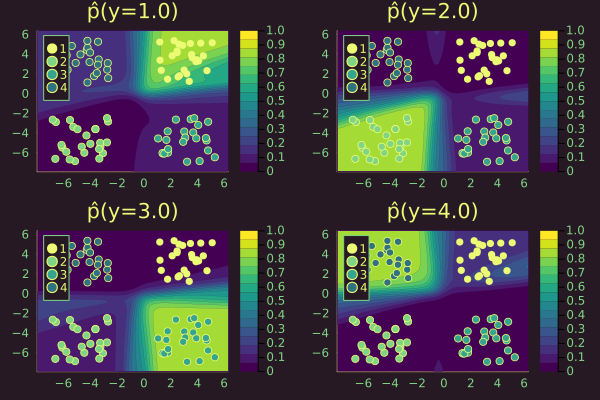

In [131]:
#| output: true

# NUMBER 1: w/ transform jacobians

la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, data)

_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [118]:
la.posterior.H

25×25 Matrix{Float64}:
  0.0441446     0.00725547   -0.198117    …  -0.0579746   -0.0302724
  0.00725547    0.00627713   -0.0677195      -0.0117913    0.0108213
 -0.198117     -0.0677195     2.64129         0.761872    -0.421524
 -0.0677195    -0.0384126     1.31856         0.429457    -0.559046
  7.14295e-6   -7.23296e-5    0.0058786       0.0157155   -0.0311587
 -7.23296e-5   -5.21322e-5    0.00633185  …  -0.142193    -0.131614
  0.00572721    0.00383123   -0.0431364      -0.025495     0.00940761
 -0.0431364    -0.0241827     0.542727        0.147553    -0.264506
  2.74214e-5    3.75044e-5    0.00319663      0.0277691   -0.0373602
  0.0569694     0.0232793    -0.0380484      -0.304138    -3.88455
  0.041813      0.00292048   -0.0716952   …  -0.755918    -0.183637
  0.0671259     0.0156406     0.0550465      -0.963265    -1.79035
  0.0229621    -0.00854415   -0.0425147      -0.00466223  -0.268186
 -0.00387331   -0.00463278   -0.2307         -2.38544     -0.0420254
 -0.000732544  -0.00

In [132]:
pred_w = predict(la, X)

4×100 Matrix{Float64}:
 0.82248     0.823149   0.821861    …  0.133897    0.138249    0.136206
 0.00174597  0.0017722  0.00187261     0.0279448   0.0300436   0.0284961
 0.023541    0.0239181  0.0246508      0.00555971  0.00598087  0.0057259
 0.152233    0.151161   0.151615       0.832598    0.825727    0.829572

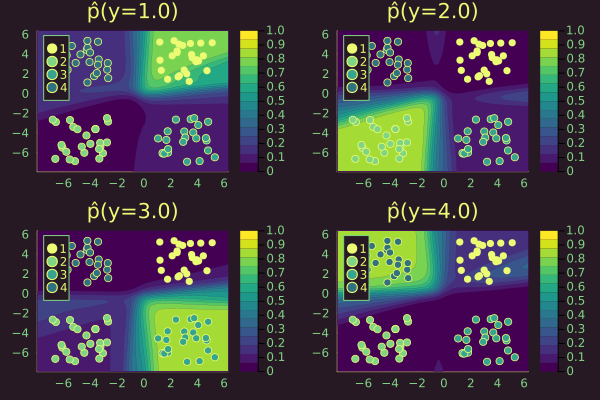

In [126]:
#| output: true

# NUMBER 2: w/out transform jacobians
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, data)

_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [127]:
pred_wout = predict(la, X)

4×100 Matrix{Float64}:
 0.810241    0.810821    0.809477    …  0.142657    0.146718    0.144923
 0.00168821  0.00171293  0.00180817     0.0296004   0.0317516   0.0301703
 0.0251322   0.0255428   0.0263024      0.00581241  0.00624297  0.00598436
 0.162938    0.161923    0.162413       0.82193     0.815287    0.818922

In [138]:
pred_w

4×100 Matrix{Float64}:
 0.82248     0.823149   0.821861    …  0.133897    0.138249    0.136206
 0.00174597  0.0017722  0.00187261     0.0279448   0.0300436   0.0284961
 0.023541    0.0239181  0.0246508      0.00555971  0.00598087  0.0057259
 0.152233    0.151161   0.151615       0.832598    0.825727    0.829572

In [152]:
isapprox(pred_wout, pred_w, atol=.134)

true

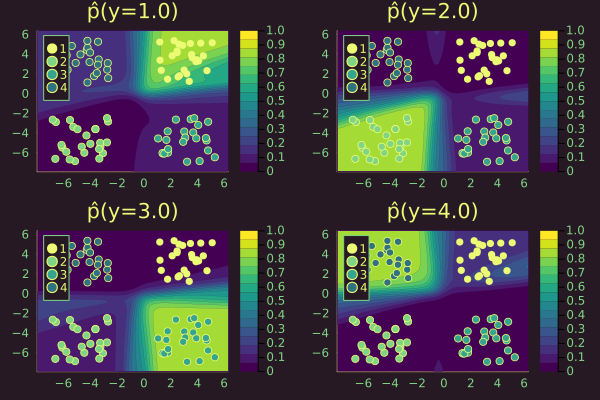

In [174]:
#| output: true

# NUMBER 2: w/out transform jacobians
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, data)

_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [154]:
pred_wout_wout = predict(la, X)

4×100 Matrix{Float64}:
 0.82248     0.823149   0.821861    …  0.133897    0.138249    0.136206
 0.00174597  0.0017722  0.00187261     0.0279448   0.0300436   0.0284961
 0.023541    0.0239181  0.0246508      0.00555971  0.00598087  0.0057259
 0.152233    0.151161   0.151615       0.832598    0.825727    0.829572

In [155]:
isapprox(pred_wout_wout, pred_w)
# NOTE: these are predictions obtained after correcting both Jacobians and gradients to read column-order

true

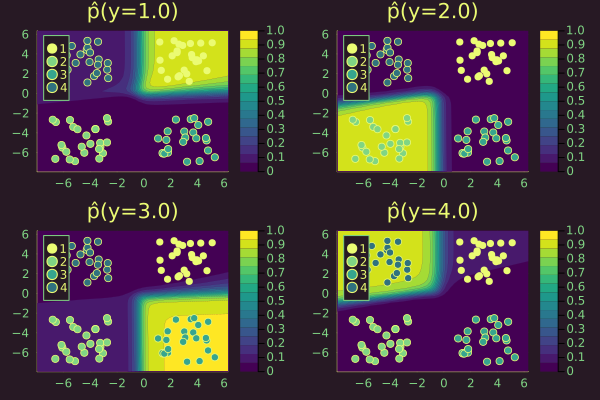

In [175]:
#| output: true

# PLUGIN APPROXIMATION -- NO UNCERTAINTY
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1), link_approx=:plugin)
    push!(plt_list, plt)
end
plot(plt_list...)